In [1]:
import torchphysics as tp
import numpy as np
import torch
from matplotlib import pyplot as plt

# PINNs in TorchPhysics for Parameter-Dependent PDEs
In the previous [tutorial](https://github.com/TomF98/torchphysics/blob/main/examples/tutorial/Introduction_Tutorial_PINNs.ipynb), we solved a single PDE by PINNs in TorchPhysics. However, it is desirable to solve PDEs for different parameters choices simultaneously. Below, we want to illustrate that the PINN approach is also capable of solving parameter-dependent PDEs.

Again, consider the time-dependent heat equation for a perfectly insulated room $\Omega\subset \mathbb{R}^2$ in which a heater is turned on. We introduce the thermic diffusivity $\color{red}{a \in A:= [0.1, 1]}$ as well as the time $\color{red}{p\in P:=[3, 10]}$ at which the heater reaches its maximal temperature as parameters for the PDE.
$$
\begin{cases}
\frac{\partial}{\partial t} u(x,t) &= \color{red}{a} \Delta_x u(x,t) &&\text{ on } \Omega\times I, \\
u(x, t) &= u_0 &&\text{ on } \Omega\times \{0\},\\
u(x,t) &= h(t, \color{red}{p}) &&\text{ at } \partial\Omega_{heater}\times I, \\
\nabla_x u(x, t) \cdot \overset{\rightarrow}{n}(x) &= 0 &&\text{ at } (\partial \Omega \setminus \partial\Omega_{heater}) \times I.
\end{cases}
$$
The initial room (and heater) temperature is $u_0 = 16$. The time domain is the interval $I = (0, 20)$, whereas the domain of the room is $\Omega=(5,0) \times (4,0)$. The heater is located at $\partial\Omega_{heater} = [1,3] \times \{4\}$ and the temperature of the heater is described by the function $h$ defined below.

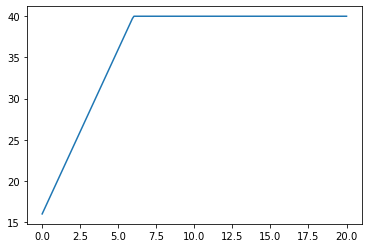

In [2]:
u_0          = 16 # initial temperature
u_heater_max = 40 # maximal temperature of the heater

# heater temperature function
def h(t, p):
    # p: time at which the heater reaches its maximal temperature
    ht = u_0 + (u_heater_max - u_0) / p * t
    ht[t>p] = u_heater_max
    return ht

# Visualize h(t, p) for fixed p
t = np.linspace(0, 20, 200)
p = 6
plt.plot(t, h(t, p))
plt.show()

Most of the code remains the same compared to the first Tutorial. In the following we rewrite the code from the first Tutorial and indicate where changes are required.

# Translating the PDE Problem into the Language of TorchPhysics

### Step 1: Specify spaces and domains

In [3]:
# Input and output spaces
X = tp.spaces.R2(variable_name='x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

# Domains
Omega = tp.domains.Parallelogram(space=X, origin=[0,0], corner_1=[5,0], corner_2=[0,4])
I     = tp.domains.Interval(space=T, lower_bound=0, upper_bound=20)

In addition, we need to define own TorchPhysics Spaces and Domains for the parameters $a\in A\subset \mathbb{R}$ and $p\in P \subset\mathbb{R}$.

In [4]:
# Parameter spaces
A_space = tp.spaces.R1('a')
P_space = tp.spaces.R1('p')

A     = tp.domains.Interval(A_space, 0.1, 1.)
P     = tp.domains.Interval(P_space, 3, 10)

### Step 2: Define point samplers for different subsets of $\overline{\Omega\times I\times A \times P}$
You may have noticed the little change in the caption of Step 2. Since the neural network should solve the PDE for every parameter $a\in A$ and $p\in P$, its input space must be $\overline{\Omega\times I\times A \times P}$. Therefore, all samplers must sample points within this extended domain.

In [5]:
domain_pde_condition = Omega * I * A * P
sampler_pde_condition = tp.samplers.RandomUniformSampler(domain=domain_pde_condition, n_points=15000)

Similarly for the samplers corresponding to the initial and boundary conditions:

In [6]:
domain_initial_condition  = Omega * I.boundary_left * A * P
sampler_initial_condition    = tp.samplers.RandomUniformSampler(domain_initial_condition, 5000)

domain_boundary_condition  = Omega.boundary * I * A * P
sampler_boundary_condition =  tp.samplers.RandomUniformSampler(domain_boundary_condition, 5000)

### Step 3: Define residual functions
The residual for the pde condition requires the thermal diffusivity $a$ as an input.

In [7]:
def residual_pde_condition(u, x, t, a):
    return a * tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

The residual for the intial condition remains unchanged.

In [8]:
def residual_initial_condition(u):
    return u - u_0

The Dirichlet condition depends on $p$, the time when the heater reaches its maximal temperature.

In [9]:
def residual_dirichlet_condition(u, t, p):
    return u - h(t, p)

The Neumann conditions remains unchanged.

In [10]:
def residual_neumann_condition(u, x):
    normal_vectors    = Omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    return normal_derivative 

Of course, the residual of the combined boundary condition requires $p$ as an input, too.

In [11]:
def residual_boundary_condition(u, x, t, p):
    # Create boolean tensor indicating which points x belong to the dirichlet condition (heater location)
    heater_location           = (x[:, 0] >= 1 ) & (x[:, 0] <= 3) & (x[:, 1] >= 3.99)    
    # First compute Neumann residual everywhere, also at the heater position
    residual                  = residual_neumann_condition(u, x)
    # Now change residual at the heater to the Dirichlet residual
    residual_h                = residual_dirichlet_condition(u, t, p)
    residual[heater_location] = residual_h[heater_location]
    return residual

### Step 4: Define Neural Network
As already mentioned, the input of our model should belong to $\overline{\Omega\times I\times A\times P}$. Moreover, we slightly increase the size of the fully connected layers, since this time the model needs to learn more.

In [12]:
normalization_layer = tp.models.NormalizationLayer(Omega*I*A*P)

fcn_layer           = tp.models.FCN(input_space=X*T*A_space*P_space, output_space=U, hidden = (80,80,50,50))

model               = tp.models.Sequential(normalization_layer, fcn_layer)

### Step 5: Create TorchPhysics Conditions
Here, nothing needs to be changed.

In [13]:
pde_condition      = tp.conditions.PINNCondition(module     =model, 
                                                 sampler    =sampler_pde_condition,
                                                 residual_fn=residual_pde_condition)

initial_condition  = tp.conditions.PINNCondition(module     =model, 
                                                 sampler    =sampler_initial_condition,
                                                 residual_fn=residual_initial_condition)

boundary_condition = tp.conditions.PINNCondition(module     =model, 
                                                 sampler    =sampler_boundary_condition,
                                                 residual_fn=residual_boundary_condition)

# Training based on Pytorch Lightning 
Also in the training part, everything remains as it was.

In [14]:
import pytorch_lightning as pl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

In [15]:
training_conditions = [pde_condition, initial_condition, boundary_condition]

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.007)

solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

In [19]:
# Start the training
trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=500, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)

trainer.fit(solver) # start training

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.055     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Visualization
Of course, we could again use the plot() function from "tp.utils" to visualize the solution for fixed time $t$ and parameters $a, p$, like we did in the first PINNs Tutorial. However, it is  to create an animation over time for different parameter choices. For this purpose we create an AnimationSampler (instead of a PlotSampler). 

In [51]:
a = 0.11
p = 4
plot_sampler = tp.samplers.AnimationSampler(plot_domain=Omega, animation_domain=I,
                                            frame_number=20, n_points=600, 
                                            data_for_other_variables={'a':a, 'p':p})

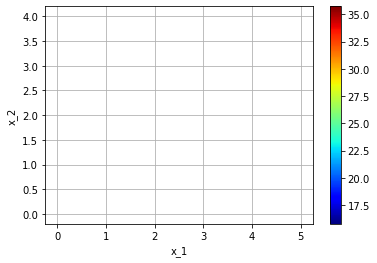

In [56]:
fig, animation = tp.utils.animate(model, lambda u : u, plot_sampler, ani_type='contour_surface', ani_speed=1)

In [57]:
animation.save(f'animation_tut_2_a{a}_p{p}.gif')